# Used Car Sales Project

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoostRegressor
import xgboost as xgb

## Data Inspection & Preprocessing

In [17]:
df = pd.read_csv("car_data.csv")
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [18]:
df.dtypes

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Mileage               int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

In [19]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [20]:
df = df.drop(["DateCrawled","DateCreated","PostalCode","LastSeen"], axis = 1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0


I have removed the columns above due to the fact that they won't affect the price variable.

In [21]:
df.corr()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN
Mileage,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df = df.drop(["NumberOfPictures"],axis = 1)

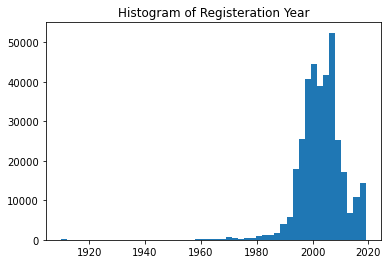

In [23]:
df = df[df["RegistrationYear"] > 1900]
df = df[df["RegistrationYear"] < 2050]
df.reset_index()
plt.hist(df["RegistrationYear"],bins = 50)
plt.title("Histogram of Registeration Year")
plt.show()

It seems that outliers still exist so I'll do some more outlier handling

In [24]:
df = df[df["RegistrationYear"] > 1960]
df = df[df["RegistrationYear"] < 2020]
df.reset_index()


,index,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...,...
353649,354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
353650,354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN
353651,354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
353652,354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


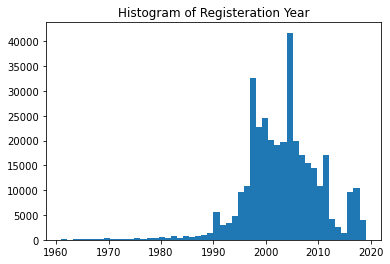

In [25]:
plt.hist(df["RegistrationYear"],bins = 50)
plt.title("Histogram of Registeration Year")
plt.show()

In [26]:
df.isnull().sum(axis=0)/ df.shape[0] * 100

Price                 0.000000
VehicleType          10.497548
RegistrationYear      0.000000
Gearbox               5.499726
Power                 0.000000
Model                 5.479650
Mileage               0.000000
RegistrationMonth     0.000000
FuelType              9.202780
Brand                 0.000000
NotRepaired          19.991008
dtype: float64

In [27]:
df = df.fillna("unknown")
df.isnull().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

## Encoding

In [28]:
df_OHE = df
df_OHE = pd.get_dummies(df_OHE)
df_OHE.head()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_unknown,NotRepaired_yes
0,480,1993,0,150000,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,18300,2011,190,125000,5,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,6,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,3600,2008,69,90000,7,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [29]:
categorical_features = ["VehicleType","Gearbox","Model","FuelType","Brand","NotRepaired"]

In [30]:
df_ordinal = df.copy()
df_ordinal[categorical_features] = OrdinalEncoder().fit_transform(df[categorical_features])
df_ordinal.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,7.0,1993,1.0,0,116.0,150000,0,6.0,38.0,1.0
1,18300,2.0,2011,1.0,190,228.0,125000,5,2.0,1.0,2.0
2,9800,6.0,2004,0.0,163,117.0,125000,8,2.0,14.0,1.0
3,1500,5.0,2001,1.0,75,116.0,150000,6,6.0,38.0,0.0
4,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0


## Model training & Deployment

In [31]:
ind_train_val, ind_test =train_test_split(df.index,test_size = 0.3,random_state = 12345)
ind_train,ind_val = train_test_split(ind_train_val,test_size = 0.25,random_state=12345)

df_train = df.loc[ind_train]
df_valid= df.loc[ind_val]
df_test = df.loc[ind_test]

df_ordinal_train = df_ordinal.loc[ind_train]
df_ordinal_valid = df_ordinal.loc[ind_val]
df_ordinal_test = df_ordinal.loc[ind_test]

df_OHE_train = df_OHE.loc[ind_train]
df_OHE_valid = df_OHE.loc[ind_val]
df_OHE_test = df_OHE.loc[ind_test]

def rmse(y,x):
    return mean_squared_error(y,x) ** 0.5

pred_mean = np.ones(df_test["Price"].shape) * df_test["Price"].mean()
print(rmse(df_test["Price"],pred_mean))

4516.04752927593


### Linear Regression

In [32]:
%%time 
model = LinearRegression()
model.fit(df_ordinal_train.iloc[:,1:],df_ordinal_train.iloc[:,0])

Wall time: 143 ms


LinearRegression()

In [33]:
pred_train = model.predict(df_ordinal_train.iloc[:, 1:])
pred_valid = model.predict(df_ordinal_valid.iloc[:, 1:])
pred_test = model.predict(df_ordinal_test.iloc[:, 1:])

print("Train RMSE: ",rmse(df_ordinal_train.iloc[:,0],pred_train).round(5))
print("Valid RMSE: ",rmse(df_ordinal_valid.iloc[:,0],pred_valid).round(5))
print("Test RMSE: ",rmse(df_ordinal_test.iloc[:,0],pred_test).round(5))

Train RMSE:  3435.09367
Valid RMSE:  3415.26185
Test RMSE:  3448.02771


## Gradient Descent Techniques

### LightGBM

In [34]:
%%time 

model = lgb.LGBMRegressor(num_iteration = 100,veboos = 1, metric = "rmse")
model.fit(df_ordinal_train.iloc[:,1:],df_ordinal_train.iloc[:,0],
         eval_set=(df_ordinal_valid.iloc[:,1:],df_ordinal_valid.iloc[:,0]),
         categorical_feature = categorical_features)

C:\Users\rodri\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\rodri\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\rodri\anaconda3\lib\site-packages\lightgbm\basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\rodri\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\rodri\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_col

[LightGBM] [Warning] Unknown parameter: veboos
[LightGBM] [Warning] num_iterations is set=100, num_iteration=100 will be ignored. Current value: num_iterations=100
[1]	valid_0's rmse: 4189.39
[2]	valid_0's rmse: 3915.51
[3]	valid_0's rmse: 3669.37
[4]	valid_0's rmse: 3453.12
[5]	valid_0's rmse: 3264.97
[6]	valid_0's rmse: 3100.15
[7]	valid_0's rmse: 2953.68
[8]	valid_0's rmse: 2823.04
[9]	valid_0's rmse: 2708.34
[10]	valid_0's rmse: 2608.56
[11]	valid_0's rmse: 2520.74
[12]	valid_0's rmse: 2442.84
[13]	valid_0's rmse: 2375.78
[14]	valid_0's rmse: 2313.41
[15]	valid_0's rmse: 2260.92
[16]	valid_0's rmse: 2214.54
[17]	valid_0's rmse: 2174.01
[18]	valid_0's rmse: 2135.2
[19]	valid_0's rmse: 2103.73
[20]	valid_0's rmse: 2075.86
[21]	valid_0's rmse: 2049.45
[22]	valid_0's rmse: 2026.3
[23]	valid_0's rmse: 2005.38
[24]	valid_0's rmse: 1987.86
[25]	valid_0's rmse: 1971.23
[26]	valid_0's rmse: 1956.8
[27]	valid_0's rmse: 1943.65
[28]	valid_0's rmse: 1932.5
[29]	valid_0's rmse: 1922.3
[30]	vali

LGBMRegressor(metric='rmse', num_iteration=100, veboos=1)

In [35]:
pred_train = model.predict(df_ordinal_train.iloc[:, 1:])
pred_valid = model.predict(df_ordinal_valid.iloc[:, 1:])
pred_test = model.predict(df_ordinal_test.iloc[:, 1:])

In [36]:
print("Train RMSE: ",rmse(df_ordinal_train.iloc[:,0],pred_train).round(5))
print("Valid RMSE: ",rmse(df_ordinal_valid.iloc[:,0],pred_valid).round(5))
print("Test RMSE: ",rmse(df_ordinal_test.iloc[:,0],pred_test).round(5))

Train RMSE:  1707.78872
Valid RMSE:  1773.52582
Test RMSE:  1779.55759


### CatBoostRegressor

In [37]:
%%time
model = CatBoostRegressor(iterations = 100,cat_features= categorical_features, metric_period = 50)
model.fit(df_train.iloc[:,1:],df_train.iloc[:,0],
         eval_set=(df_valid.iloc[:,1:],df_valid.iloc[:,0]))

Learning rate set to 0.5
0:	learn: 3283.1966579	test: 3283.6221259	best: 3283.6221259 (0)	total: 246ms	remaining: 24.4s
50:	learn: 1836.2282637	test: 1862.5200849	best: 1862.5200849 (50)	total: 4.35s	remaining: 4.18s
99:	learn: 1765.9104639	test: 1817.7692691	best: 1817.7692691 (99)	total: 8.24s	remaining: 0us

bestTest = 1817.769269
bestIteration = 99

Wall time: 8.91 s


### XGBRegressor

In [38]:
%%time 
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(df_OHE_train.iloc[:,1:],df_OHE_train.iloc[:,0])



[20:00:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 3.47 s


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [39]:
pred_train = xg_reg.predict(df_OHE_train.iloc[:, 1:])
pred_valid = xg_reg.predict(df_OHE_valid.iloc[:, 1:])
pred_test = xg_reg.predict(df_OHE_test.iloc[:, 1:])

print("Train RMSE: ",rmse(df_OHE_train.iloc[:,0],pred_train).round(5))
print("Valid RMSE: ",rmse(df_OHE_valid.iloc[:,0],pred_valid).round(5))
print("Test RMSE: ",rmse(df_OHE_test.iloc[:,0],pred_test).round(5))

Train RMSE:  3599.63615
Valid RMSE:  3592.75817
Test RMSE:  3607.32474


# Conclusion

At the beginning of the project we have imported and then inspected the data, from the inspection we were capable of asserting that there were a few minor issues with the data, those issues were: missing data, redundant columns and outliers, after asserting those we easily and quickly fixed those issues by dropping the redundant columns, filling the missing data with "Unknown" and removing the outliers from the dataset. After fixing those minor issues I encoded the data with two ways, OHE and OrdinalEncoding, both steps would be necessary for the deployment of the ML algorithms, after doing such i splitted the data and deployed a simple Linear Regression algorithm, the goal of my experiment is to see the metric difference and time of different algorithms. I deployed Linear Regression and 3 different gradient descent techniques, out of them all the one that performed the best was lightGBM(which applies the stochastic technique),it outperformed the other algorithms quite well howeverit performed the worst in terms of time, so I decided to perform hyperparameter tuning to the one that took the least time(XGBRegressor), unfortunately it wasn't capable of outperforming the lightGBM model, so in this case I believe that the best model is the lightGBM.